In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

In [2]:
def load_data(sample_number):
    # load sampling output file 
    data = np.loadtxt(f"../synthetic_data/dataset_{sample_number}/syndat_{sample_number}_output.txt")
    weights = data[:,0]
    masses = data[:,2]

    # get true mass  
    overview_file = np.loadtxt("../synthetic_data/syndat_overview.txt")
    true_mass = overview_file[sample_number-1][1] 

    return weights, masses, true_mass

For each output: 
1) Get the true value for the mass
2) Take all the weights of the masses that fall below that true value.
3) Sum up these weights
4) Store this output (should be a value between 0 and 1)/append this to a list.
That final list should be uniformly distributed if your sampler works correctly. 

In [90]:
N = 10 # sample size 
credible_levels = []

for i in np.arange(N):

    # get data 
    sample_number = i+1
    weights, masses, true_mass = load_data(sample_number)
 
    # get indices of all masses that fall below true mass 
    ind = np.where(masses < true_mass)

    # get corresponding weights 
    weights_below_true_mass = weights[ind]

    # store sum of these weights 
    credible_levels.append(np.sum(weights_below_true_mass)/np.sum(weights)) # IS THE / NEEDED FOR MY SUM OF WEIGHTS IS ALMOST 1 ALREADY

# needed later 
credible_levels = np.array(credible_levels)
credible_levels

1.7022664567573075e-06
0.03060143727535666
8.941532986855716e-21
7.204300071258814e-30
6.366851610955465e-129
1.0
0.9943273476191303
1.0
2.6502777517211597e-107
2.2998928369897572e-07


array([1.70226646e-006, 3.06014373e-002, 8.94153299e-021, 7.20430007e-030,
       6.36685161e-129, 1.00000000e+000, 9.94327348e-001, 1.00000000e+000,
       2.65027775e-107, 2.29989284e-007])

Now to create the actual image of the PP-plot:
1) Create a list with evenly spaced bins (`np.linspace(0,1,1000)`)
2) Put the values of the list in these bins. So at bin 0.6 you should have roughly 60% of all the values in the list. 

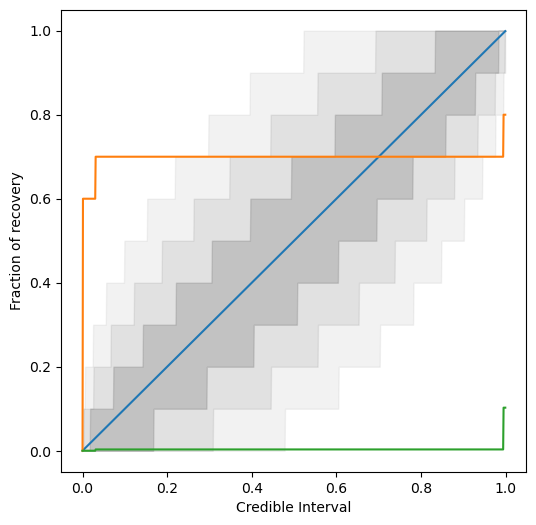

In [102]:
fig, ax = plt.subplots(figsize=(6,6))

# plot lines 
x_values = np.linspace(0., 0.999, 1001)       
pp = np.array([sum(credible_levels < xx)/len(credible_levels) for xx in x_values])

ax.plot(x_values, x_values)
ax.plot(x_values, pp)
ax.set_xlabel(r"Credible Interval")
ax.set_ylabel(r"Fraction of recovery")

# plot grey area 
confidence_interval=[0.68, 0.95, 0.997]
confidence_interval_alpha = [0.3,0.3/2,0.3/3]

for ci, alpha in zip(confidence_interval, confidence_interval_alpha):

    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, N, x_values) / N
    upper = binom.ppf(edge_of_bound, N, x_values) / N
    # The binomial point percent function doesn't always return 0 @ 0,
    # so set those bounds explicitly to be sure
    lower[0] = 0
    upper[0] = 0
    ax.fill_between(x_values, lower, upper, alpha=alpha, color='grey')

True mass: 1.3858796817826617 colortab:blue
True mass: 2.2791324782971913 colortab:orange
True mass: 1.2784010783662179 colortab:green
True mass: 1.5431231902689337 colortab:red
True mass: 2.0137948352882855 colortab:purple
True mass: 1.0904948310275742 colortab:brown
True mass: 1.9753146107787694 colortab:pink
True mass: 1.244018162021261 colortab:gray
True mass: 2.187067691149738 colortab:olive
True mass: 1.8418756781372545 colortab:cyan


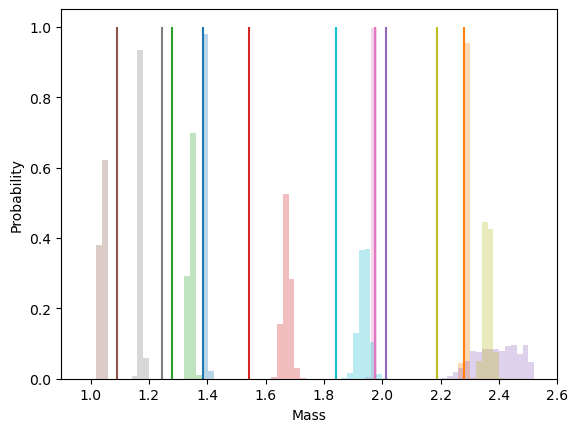

In [117]:
# Get an indication of the distribution
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in np.arange(N):

    sample_number = i+1
    weights, masses, true_mass = load_data(sample_number)

    
    plt.hist(masses, weights=weights, bins=100,  color=colors[i], alpha=0.3)
    plt.vlines(x=true_mass, ymin=0., ymax=1, colors=colors[i]);

    plt.xlim(0.9, 2.6)
    plt.xlabel("Mass")
    plt.ylabel("Probability")

    print("True mass:", true_mass, f"color{colors[i]}")

So is looks like the sampler is overestimating the mass. The probability distribution of mass is 8 of the 10 times on the right of the true mass. Try increasing the minimum number of live points to 1000 and the sampling efficiency to 0.1